## Downloading the image captioning datasets

In [ ]:
# download images and annotations to the data directory
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P ./data_dir/ -P ./data_dir/
!wget http://images.cocodataset.org/zips/train2014.zip -P ./data_dir/
!wget http://images.cocodataset.org/zips/val2014.zip -P ./data_dir/
# extract zipped images and annotations and remove the zip files
!unzip ./data_dir/annotations_trainval2014.zip -d ./data_dir/
!rm ./data_dir/annotations_trainval2014.zip
!unzip ./data_dir/train2014.zip -d ./data_dir/
!rm ./data_dir/train2014.zip
!unzip ./data_dir/val2014.zip -d ./data_dir/
!rm ./data_dir/val2014.zip

In [ ]:
import nltk
from pycocotools.coco import COCO
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
class Vocab(object):
  def __init__(self):
    self.w2i = {}
    self.i2w = {}
    self.index = 0

  def __call__(self, token):
    if token not in self.w2i:
      return self.w2i['<unk>']
    return self.w2i[token]

  def __len__(self):
    return len(self.w2i)

  def add_token(self, token):
    if token not in self.w2i:
      self.w2i[token] = self.index
      self.i2w[self.index] = token
      self.index += 1

In [ ]:
from collections import Counter

def build_vocabulary(json, threshold):
  coco = COCO(json)
  counter = Counter()
  ids = coco.anns.keys()
  for i, id in enumerate(ids):
    caption = str(coco.anns[id]['caption'])
    tokens = nltk.tokenize.word_tokenize(caption.lower())
    counter.update(tokens)
    if (i+1) % 1000 :
      print("[{}, {}] Tokenized the captions.".format(i+1, len(ids)))


  tokens = [token for token, cnt in counter.items() if cnt>=threshold]
  vocab = Vocab()
  vocab.add_token('<pad>')
  vocab.add_token('<start>')
  vocab.add_token('<end>')
  vocab.add_token('<unk>')


  for i, token in enumerate(tokens):
    vocab.add_token(token)

  return vocab

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
vocab = build_vocabulary(json='data_dir/annotations/captions_train2014.json', threshold=4)
vocab_path = './data_dir/vocabulary.pkl'

In [ ]:
import pickle

with open(vocab_path, 'wb') as f:
  pickle.dump(vocab, f)

In [ ]:
len(vocab)

9948

## Preprocessing image data

In [ ]:
import os
from PIL import Image

def reshape_image(image, shape):
  return image.resize(shape, Image.LANCZOS)


def reshape_images(image_path, output_path, shape):
  if not os.path.exists(output_path):
        os.makedirs(output_path)

  images = os.listdir(image_path)
  num_im = len(images)

  for i, im in enumerate(images):
    with open(os.path.join(image_path, im), 'r+b') as f:
      with Image.open(f) as image:
        image = reshape_image(image, shape)
        image.save(os.path.join(output_path, im), image.format)

    if (i+1) % 100 == 0:
          print ("[{}/{}] Resized the images and saved into '{}'."
                 .format(i+1, num_im, output_path))

In [ ]:
image_path = './data_dir/train2014/'
output_path = './data_dir/resized_images/'
image_shape = [256, 256]
reshape_images(image_path, output_path, image_shape)

In [ ]:
from torch.utils.data import Dataset
import torch

class CustomCocoDataset(Dataset):
  def __init__(self, data_path, coco_json_path, vocabulary, transform=None):
    self.root = data_path
    self.coco_data = COCO(coco_json_path)
    self.indices = list(self.coco_data.anns.keys())
    self.vocabulary = vocabulary
    self.transform = transform


  def __getitem__(self, idx):
    coco_data = self.coco_data
    annotation_id = self.indices[idx]
    image_id = coco_data.anns[annotation_id]['image_id']
    vocabulary = self.vocabulary
    image_path = coco_data.loadImgs(image_id)[0]['file_name']

    image = Image.open(os.path.join(self.root, image_path)).convert('RGB')
    if self.transform is not None:
      image = self.transform(image)

    # caption
    caption = coco_data.anns[annotation_id]['caption']
    word_tokens = nltk.tokenize.word_tokenize(str(caption).lower())
    caption = []
    caption.append(vocabulary('<start>'))
    caption.extend([vocabulary(token) for token in word_tokens])
    caption.append(vocabulary('<end>'))
    ground_truth = torch.Tensor(caption)

  def __len__(self):
    return len(self.indices)

In [ ]:
def collate_function(data_batch):
  # sort data based on their caption length (desc oreder)
  data_batch.sort(key=lambda d: len(d[1]), reverse=True)
  # unpack a batch of paired data
  imgs, caps = zip(*data_batch)
  # convert to single batch tensor
  imgs = torch.stack(imgs, 0)
  # caption length lists
  cap_lens = [len(cap) for cap in caps]
  # making empty tensor with int64 (captions)
  tgts = torch.zeros(len(caps), max(cap_lens)).long()
  # fiiling tgts with captions (it is already padded!)
  for i, cap in enumerate(caps):
    end = cap_lens[i]
    tgts[i, :end] = cap[:end]

  ### OUTPUT
  # imgs:tensor(batch_size, 3, 224, 224)
  # caption with padding:tensor(batch_size, padded_length)
  # caption_length : list(batch_size)
  return imgs, tgts, cap_lens

In [ ]:
def get_loader(data_path, coco_json_path, vocabulary, transform, batch_size, shuffle):
  # coco dataset
  coco_dataset = CustomCocoDataset(data_path=data_path,
                       coco_json_path=coco_json_path,
                       vocabulary=vocabulary,
                       transform=transform)

  # custom data loader
  custom_data_loader = torch.utils.data.DataLoader(dataset=coco_dataset,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              collate_fn=collate_function)

  return custom_data_loader

# CNN-LSTM model

In [1]:
import torch.nn as nn
import torchvision.models as models


class CNNModel(nn.Module):
  def __init__(self, embedding_size):
    super().__init__()
    # load ResNet-152
    resnet = models.resnet152(pretrained=True)
    module_list = list(resnet.children())[:-1]
    self.resnet_module = nn.Sequential(*module_list)
    self.linear_layer = nn.Linear(self.resnet.fc.in_features, embedding_size)
    self.batch_norm = nn.BatchNorm1d(embedding_size, momentum=0.01)

  def forward(self, input_images):
    with torch.no_grad():
      resnet_features = self.resnet_module(input_images)
      resnet_features = resnet_features.reshape(resnet_features.size(0), -1)
      final_features = self.batch_norm(self.linear_layer(resnet_features))
    return final_features

In [ ]:
class LSTMModel(nn.Module):
  def __init__(self, embedding_size, hidden_layer_size, vocabulary_size, num_layers, max_seq_len=20):
    super().__init__()
    self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size)
    self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, num_layers, batch_first=True)
    self.linear_layer = nn.Linear(hidden_layer_size, vocabulary_size)
    self.max_seq_len = max_seq_len

  def forward(self, input_features, caps, lens):
    # calculating caption embeddings
    embeddings = self.embedding_layer(caps)
    # concatenating input features to embeddings
    embeddings = torch.cat((input_features.unsqueeze(1), embeddings), 1)
    # removes padding and allows the LSTM to process only the real parts of the seq
    lstm_input = pack_padded_sequence(embeddings, lens, batch_first=True)
    # feeding LSTM input
    hidden_variables, _ = self.lstm_layer(lstm_input)
    # use linear layer
    model_outputs = self.linear_layer(hidden_variables[0])
    return model_outputs

  def sample(self, input_features, lstm_states=None):
    """Generate captions for given image features using greedy search."""
    sampled_indices = []
    lstm_inputs = input_features.unsqueeze(1)
    for i in range(self.max_seq_len):
      hidden_variables, lstm_states = self.lstm_layer(lstm_inputs, lstm_states)          # hiddens: (batch_size, 1, hidden_size)
      model_outputs = self.linear_layer(hidden_variables.squeeze(1))            # outputs:  (batch_size, vocab_size)
      _, predicted_outputs = model_outputs.max(1)                        # predicted: (batch_size)   --> greedy search
      sampled_indices.append(predicted_outputs)
      lstm_inputs = self.embedding_layer(predicted_outputs)                       # inputs: (batch_size, embed_size)
      lstm_inputs = lstm_inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
    sampled_indices = torch.stack(sampled_indices, 1)                # sampled_ids: (batch_size, max_seq_length)
    return sampled_indices

embedding_size: The size of input features (i.e., the number of features in each time step). If you're using word embeddings, this would be the embedding dimension.

hidden_layer_size: The number of features in the hidden state of the LSTM.

num_layers: The number of stacked LSTM layers (default is 1). If more than 1, it means the LSTM is deep.

batch_first=True: Ensures that the input tensor has the shape (batch_size, seq_length, embedding_size), which is often more convenient for batch processing.

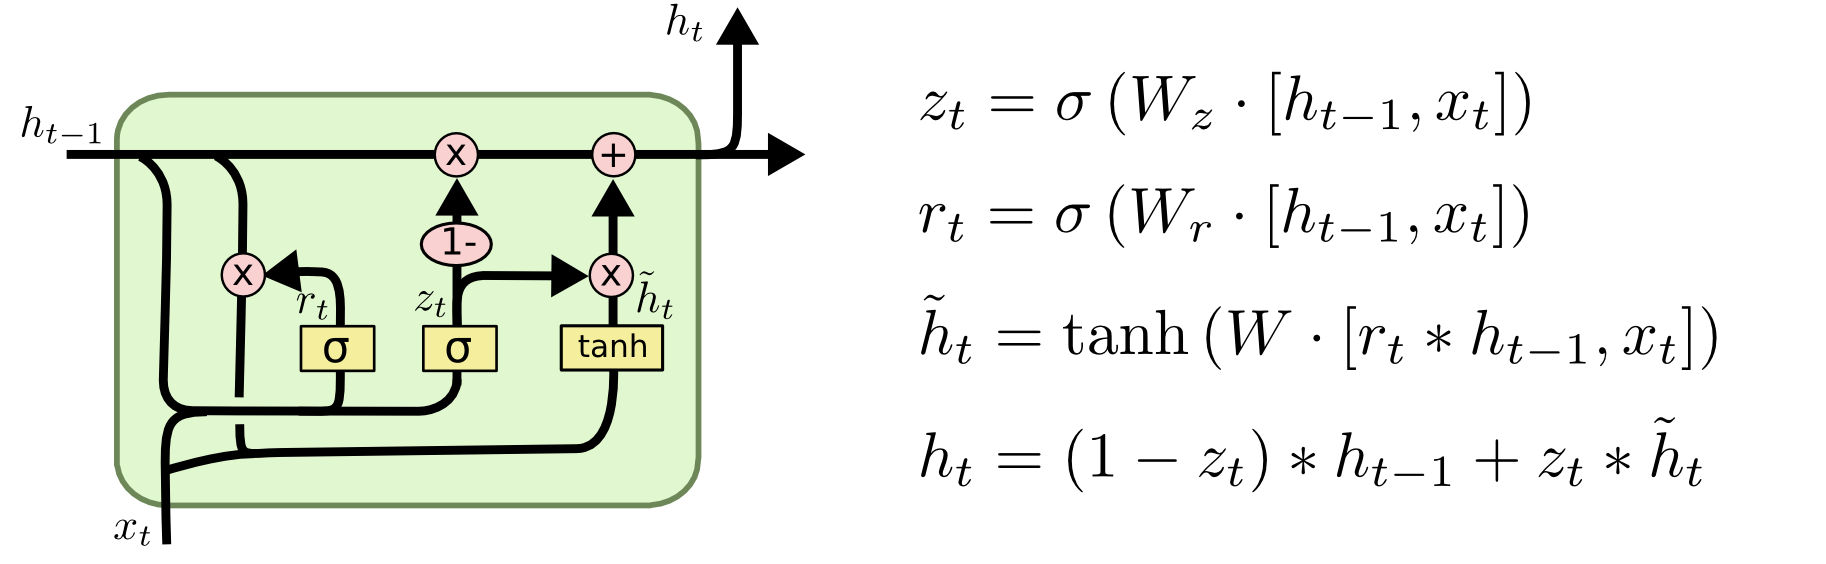

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model directory
if not os.path.exists('models_dir/'):
    os.makedirs('models_dir/')

# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

# Build data loader
custom_data_loader = get_loader('data_dir/resized_images', 'data_dir/annotations/captions_train2014.json', vocabulary,
                         transform, 128,
                         shuffle=True)

# Build the models
encoder_model = CNNModel(256).to(device)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1).to(device)


# Loss and optimizer
loss_criterion = nn.CrossEntropyLoss()
parameters = list(decoder_model.parameters()) + list(encoder_model.linear_layer.parameters()) + list(encoder_model.batch_norm.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)



In [ ]:
import numpy as np

# Train the models
total_num_steps = len(custom_data_loader)
for epoch in range(5):
    for i, (imgs, caps, lens) in enumerate(custom_data_loader):

        # Set mini-batch dataset
        imgs = imgs.to(device)
        caps = caps.to(device)
        tgts = pack_padded_sequence(caps, lens, batch_first=True)[0]

        # Forward, backward and optimize
        feats = encoder_model(imgs)
        outputs = decoder_model(feats, caps, lens)
        loss = loss_criterion(outputs, tgts)
        decoder_model.zero_grad()
        encoder_model.zero_grad()
        loss.backward()
        optimizer.step()

        # Print log info
        if i % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, 5, i, total_num_steps, loss.item(), np.exp(loss.item())))

        # Save the model checkpoints
        if (i+1) % 1000 == 0:
            torch.save(decoder_model.state_dict(), os.path.join(
                'models_dir/', 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            torch.save(encoder_model.state_dict(), os.path.join(
                'models_dir/', 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))

# predict a caption

In [ ]:
import matplotlib.pyplot as plt

image_file_path = 'sample.jpg'

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def load_image(image_file_path, transform=None):
    img = Image.open(image_file_path).convert('RGB')
    img = img.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        img = transform(img).unsqueeze(0)

    return img

# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)


# Build models
encoder_model = CNNModel(256).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1)
encoder_model = encoder_model.to(device)
decoder_model = decoder_model.to(device)


# Load the trained model parameters
encoder_model.load_state_dict(torch.load('models_dir/encoder-2-3000.ckpt'))
decoder_model.load_state_dict(torch.load('models_dir/decoder-2-3000.ckpt'))


# Prepare an image
img = load_image(image_file_path, transform)
img_tensor = img.to(device)


# Generate an caption from the image
feat = encoder_model(img_tensor)
sampled_indices = decoder_model.sample(feat)
sampled_indices = sampled_indices[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)

# Convert word_ids to words
predicted_caption = []
for token_index in sampled_indices:
    word = vocabulary.i2w[token_index]
    predicted_caption.append(word)
    if word == '<end>':
        break
predicted_sentence = ' '.join(predicted_caption)


# Print out the image and the generated caption
print (predicted_sentence)
img = Image.open(image_file_path)
plt.imshow(np.asarray(img))